In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import re
import seaborn as sns
import geopandas as gpd
import folium
import sklearn
import xgboost as xgb
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

##### Versions of the libraries used

In [3]:
print (f"pandas version: {pd.__version__}" ) 
print ( f"numpy version: {np.__version__}" ) 
python_s_version = sys.version.split()[0]
print ( f"sys version: {python_s_version}" ) 
print ( f"matplotlib version: {matplotlib.__version__}" ) 
print ( f"seaborn version: {sns.__version__}" ) 
print ( f"geopandas version: {gpd.__version__} " ) 
print ( f"folium version: {folium.__version__} " ) 
print ( f"sklearn version: {sklearn.__version__} " ) 
print ( f"xgboost version: {xgb.__version__} " ) 
print ( f"shap version: {shap.__version__} " ) 

pandas version: 2.0.1
numpy version: 1.24.3
sys version: 3.11.0
matplotlib version: 3.8.0
seaborn version: 0.12.2
geopandas version: 0.13.2 
folium version: 0.14.0 
sklearn version: 1.3.0 
xgboost version: 1.7.6 
shap version: 0.42.1 


## MACHINE LEARNING TECHNIQUES FOR CRIME PREDICTION IN FRANCE 

### Introduction

In the era of data-driven insights, this project presents an analytical exploration focused on constructing, comparing, and evaluating machine learning models. These models are deployed within the context of a database of crimes that transpired between 2016 and 2022 in France.

**The Essence of Data Preparation**

The foundation of this research is rooted in the curation of data. Efforts were dedicated to data cleansing and organization, seeking to refine and structure the initial dataset.

**Descriptive Analytics: Understand Data and Find Crucial Departments**

The journey through the dataset commenced with a phase of descriptive analysis, which led also to the creation of a graphical representations and heatmaps. These visualizations served as tools to better undestand the dataset. This section was useful to highlight cricial departmens. Moreover, heatmaps were employed to spotlight significant trends within various departments. <br>
Overall, this initial analysis was instrumental in gaining a deeper comprehension of the dataset's characteristics. It also played an important role in laying the groundwork for the subsequent, more in-depth analysis, conducted in the SHAP chapter.

**Machine Learning Frameworks: Random Forest and XGBoost**

The core of this study revolves around the application of two machine learning algorithms: Random Forest and XGBoost. These algorithms were configured to unveil their predictive potential within the context of crime data. 

**Comparative Analysis: Specialized vs. General Models**

Within the dataset, crimes are characterized by a "crime type" which considers a total of 14 distinct categories. In this section, we compare two distinct strategies: the first entails training a singular XGBoost model while incorporating the "crime type" variable as a feature. In contrast, the second strategy embarks on a more granular approach, generating individual models for each unique class, with data filtered accordingly. In other words, the aim of this chapter is to compare a generalized XGBoost model and its class-specific counterpart.

**Illuminating the Model's Black Box: SHAP Analysis**

In a pursuit to elucidate the internal workings of machine learning models, the project introduces SHAP (SHapley Additive exPlanations). The primary objective of SHAP analysis is to understand the features' importance, particularly within the context of the most adept crime prediction model found in the preceding chapter. This section undertakes a more exhaustive exploration of SHAP analysis by finding connections between feature correlations, distributions, and their relative importance in the model predictions.

**The General Objective**

The overarching objective of this study is twofold. Firstly, it exlpore various machine learning methodologies, applying them within a contest where predictive insights hold profound societal significance, addressing the issue of crimes. <br>
Secondly, the research aspires to transcend predictive capabilities, trying to enlight the causal factors underpinning crime rates. 
In essence, this research seeks to give an instrument to predict crime rate in the future and a contribute in understanding of the multifaceted phenomenon of criminality in France.

#### The datasets


This project begins with a database of crimes that transpired between 2016 and 2022 in France. <br>
Each entry in this database is characterized by the year of occurrence, a label denoting the category (crime type, with a total of 14 types), the specific department, the unit of measurement of the crime, and the number of occurrences for that type of crime in that particular department for that year.<br>
For instance, in department number 01 in the year 2016, there were 1437 victims of the crime type "Coups and blessures volontaires" (Voluntary Assaults).

Additionally, a supplementary database detailing demographic information about the departments will be used (data_info_ville). This database presents data of the departments: the population, the area, the population density, the percentage of active population, the unemployment rate, the average income and real estate prices.

These two dataframes will then be merged using the dataframe data_info_page2, that map the correspondences beetween codes and names of departments. 

In [4]:
# crime database 
path_to_database = "donnee-dep-data.gouv-2022-geographie2023-produit-le2023-07-17.csv"
data = pd.read_csv(path_to_database, sep=';')

# database complementare gendarmerie (cod,name)
file_name = "info-complements-data.gouv-2022-geographie2023-produit-le2023-07-17.xlsx"
page_number = 1  
data_info_page2 = pd.read_excel(file_name, sheet_name=page_number)

# database complementare belle-ville (departments infos)
path_to_database = "Info_complem_dep.csv"
data_info_ville = pd.read_csv(path_to_database, sep=';')

# the complete database, (without France d'outre-mer, not present in belle-ville)
filtered_data_info_page2 = data_info_page2[data_info_page2["NIVGEO"] == "DEP"]
filtered_data_info_page2 = filtered_data_info_page2.drop("NIVGEO", axis=1)
merged_data_info = filtered_data_info_page2.merge(data, left_on="CODGEO", right_on="Code.département")
merged_data_info_ville= merged_data_info.merge(data_info_ville, left_on="LIBGEO", right_on="Département")

#  GeoDataFrame 
gdf = gpd.read_file('departements.geojson')

merged_data_info_ville.head()

,CODGEO,LIBGEO,NB_COM,classe,annee,Code.département,Code.région,unité.de.compte,millPOP,millLOG,...,LOG,tauxpourmille,Département,Habitants,Superficie,Pop densité,Pop active,Taux chômage,Revenu moyen,Prix immobilier
0,01,Ain,392,Coups et blessures volontaires,16,01,84,victime,16,16,...,"308491,1600513844","2,25085170536868073",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
1,01,Ain,392,Coups et blessures volontaires,17,01,84,victime,17,17,...,"313061,4522700008","2,27558871531825568",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
2,01,Ain,392,Coups et blessures volontaires,18,01,84,victime,18,18,...,"317983,0764471052","2,36553361929731931",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
3,01,Ain,392,Coups et blessures volontaires,19,01,84,victime,19,19,...,"321432,1284726467","2,50600828898643879",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
4,01,Ain,392,Coups et blessures volontaires,20,01,84,victime,20,20,...,"325430,9391892830","2,50510750072964283",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²


## Data Cleaning

The initial step in this project involves a data cleansing process where several aspects are addressed:
- **Data Language**: to enhance the comprehensibility of the analysis, the column names  in the DataFrame will be converted to English.

In [6]:
column_mapping = {
    'classe': 'crime type',
    'annee': 'year',
    'Code.département' : 'Departement code',
    'Code.région' : 'Region code',
    'unité.de.compte' : 'unit',
    'faits' : 'occurrences',
    'tauxpourmille' : 'perthousandrate',
    'Département': 'Department',
    'Habitants': 'Population',
    'Superficie': 'Area',
    'Pop densité': 'Population Density',
    'Pop active': 'Active Population',
    'Taux chômage': 'Unemployment Rate',
    'Revenu moyen': 'Average Income',
    'Prix immobilier': 'House Price'
}

columns= ['crime type',	'year','unit', 'perthousandrate',	'Department', 'Population' ,'Area',	'Population Density','Active Population','Unemployment Rate','Average Income','House Price' ]

merged_data_info_ville
merged_data_info_ville.rename(columns=column_mapping, inplace=True)
merged_data_info_ville[columns].head()

,crime type,year,unit,perthousandrate,Department,Population,Area,Population Density,Active Population,Unemployment Rate,Average Income,House Price
0,Coups et blessures volontaires,16,victime,"2,25085170536868073",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
1,Coups et blessures volontaires,17,victime,"2,27558871531825568",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
2,Coups et blessures volontaires,18,victime,"2,36553361929731931",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
3,Coups et blessures volontaires,19,victime,"2,50600828898643879",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²
4,Coups et blessures volontaires,20,victime,"2,50510750072964283",Ain,654 869,5 749 km²,114 h/km²,48.4%,4.8%,23 598 €/an,1 941 €/m²


- **Data Integrity**: ensure numeric data fall within valid ranges and dates have correct formats and are in the desired normal form. Check for duplicate data or duplicate records in the database.

- **Handling Missing Data**: identify and manage missing data. In the case of the 3 missing values of House Price, they have been substitued with the average of the valid data. This decision was made to preserve data integrity and avoid data loss. 

- **Data Accuracy Check**: review data to identify obvious errors, such as values that violate domain rules.

- **Cross-Data Validation**: in order to merge various datasets, a thorough cross-data validation process is conducted. Particular attention is dedicated to resolving discrepancies, such as variations in department names and spellings. (1,2)

In [8]:
def clean_and_filter_data(df):
    print(f"Length before the Cleaning Process: {len(df)}")
  
    duplicated_data = df[df.duplicated()]  #duplicates
    valid_rows =  (df[~duplicated_data])

    valid_rows = (df['year'].astype(str).str.isnumeric()) & (df['year'].astype(int).between(16, 22)) #verify that all 'year' are integers and within the range of 16 to 22.
    
    valid_departments = ['{:02d}'.format(i) for i in range(1, 96)] + ['2A', '2B'] #verify that the 'Departement code' column contains values beetween 01 and 95, 2A and 2B, no outre-mer
    valid_rows = (df['Departement code'].astype(str).isin(valid_departments))
    
    valid_regions = [str(i).zfill(2) for i in range(1, 95)] #check and remove not valid rows for 'Region code
    valid_rows = (df['Region code'].astype(str).isin(valid_regions))
    
    valid_units = ['victime', 'victime entendue', 'infraction', 'véhicule', 'Mis en cause'] #check and remove not valid rows for 'unit'
    valid_rows = (df['unit'].isin(valid_units))
    
    df['Population'] = df['Population'].str.replace(' ', '').astype(int) 
    valid_rows = (df['Population'] > 0)

    valid_rows = df['occurrences'].astype(str).str.isdigit() #null values are removed
    
    valid_rows = valid_rows & (df['POP'] > 0)   
    
    df['perthousandrate'] = df['perthousandrate'].str.replace(',', '.').astype(float) 
    valid_rows = valid_rows & (df['perthousandrate'] >= 0)  

    df['Area'] = df['Area'].apply(lambda x: re.sub(r'[^\d]', '', x)) #symbols are removed 
    df['Area'] = df['Area'].astype(int) 
    valid_rows = valid_rows & (df['Area'] > 0)

    df['Population Density'] = df['Population Density'].apply(lambda x: re.sub(r'[^\d]', '', x))
    df['Population Density'] = df['Population Density'].astype(int) #there are no null values, errors would be occurred
    valid_rows = valid_rows & (df['Population Density'] > 0)

    df['Active Population'] = df['Active Population'].apply(lambda x: re.sub(r'[^\d]', '', x))
    df['Active Population'] = df['Active Population'].apply(lambda x: int(x) / 10 if len(x) == 3 else int(x)) #these are percentages. There are no null values
    valid_rows = valid_rows & (df['Active Population'].between(0, 100))  
    valid_rows = valid_rows & (~df['Active Population'].isnull())  

    df['Unemployment Rate'] = df['Unemployment Rate'].apply(lambda x: re.sub(r'[^\d]', '', x))
    df['Unemployment Rate'] = df['Unemployment Rate'].apply(lambda x: int(x) / 10 if len(x) == 2 else int(x)) #there are no null values
    valid_rows = valid_rows & (df['Unemployment Rate'].between(0, 100))  
    valid_rows = valid_rows & (~df['Unemployment Rate'].isnull())  

    df['Average Income'] = df['Average Income'].apply(lambda x: re.sub(r'[^\d]', '', x))
    df['Average Income'] = df['Average Income'].astype(int)
    valid_rows = valid_rows & (df['Average Income'] > 0)

    df['House Price'] = df['House Price'].apply(lambda x: re.sub(r'[^\d]', '', x)) #remove non-numeric characters from the 'House Price' column.
    nc_rows = df['House Price'] == '' #identify 'NC' rows 
    mean_prix_immobilier = df[~nc_rows]['House Price'].astype(int).mean() #calculate the  average of the valid values
    df.loc[nc_rows, 'House Price'] = mean_prix_immobilier #replace 'NC' values with the mean of valid values
    df['House Price'] = df['House Price'].astype(int) 
    valid_rows = valid_rows & (df['House Price'] >= 0) 

    df = df[valid_rows]
    print(f"Length after the Cleaning Process: {len(df)}")
    return df

In [9]:
columns= ['crime type',	'year','unit', 'perthousandrate',	'Department', 'Population' ,'Area',	'Population Density','Active Population','Unemployment Rate','Average Income','House Price' ]
merged_data_info_ville = clean_and_filter_data(merged_data_info_ville)
merged_data_info_ville[columns].head()

Length before the Cleaning Process: 9408
Length after the Cleaning Process: 9408


,crime type,year,unit,perthousandrate,Department,Population,Area,Population Density,Active Population,Unemployment Rate,Average Income,House Price
0,Coups et blessures volontaires,16,victime,2.250852,Ain,654869,5749,114,48.4,4.8,23598,1941
1,Coups et blessures volontaires,17,victime,2.275589,Ain,654869,5749,114,48.4,4.8,23598,1941
2,Coups et blessures volontaires,18,victime,2.365534,Ain,654869,5749,114,48.4,4.8,23598,1941
3,Coups et blessures volontaires,19,victime,2.506008,Ain,654869,5749,114,48.4,4.8,23598,1941
4,Coups et blessures volontaires,20,victime,2.505108,Ain,654869,5749,114,48.4,4.8,23598,1941


## Descriptive Analysis

In the initial phase, a Descriptive Analysis was conducted. <br>

#### Critical departments:

It was interesing to find the most critical departments within the dataset. To facilitate this task, a function was crafted. This function identifies department where a higher per thousand rate ('perthousandrate') is observed for a specific crime type.

The "perthousandrate" value indicates the number of recorded delinquency incidents ("occurrences") per one thousand inhabitants within a specific municipality.

This function serves a future purpose. We will later invoke this function when needing the geographic trends associated with the crime type "Vols avec armes" (armed robberies). Indeed, later the the class-specific model focusing on "Vols avec armes" (armed robberies) will emerge as the superior model, warranting in-depth analysis that will be done in the SHAP Analysis chapter.

In [10]:
def top_dep_per_crime_type( crime_type):
    filtered_data = merged_data_info_ville[merged_data_info_ville["crime type"] == crime_type]
    grouped_data = filtered_data.groupby('Department')['perthousandrate'].sum().reset_index()
    sorted_data = grouped_data.sort_values(by='perthousandrate', ascending=False)
    top_5_departments = sorted_data.head(5)
    return top_5_departments

top_5_departments = top_dep_per_crime_type("Coups et blessures volontaires") #example, quale metto???
top_5_departments.head()

,Department,perthousandrate
81,Seine-Saint-Denis,46.238378
71,Paris,40.350658
68,Nord,38.306538
12,Bouches-du-Rhône,36.954571
3,Alpes-Maritimes,35.489739


#### Graphs 

Moving to Descriptive Analysis, some graphs are useful for data exploration. <br>

The first function creates a **scatter plot** to visualize the correlation between the "perthousandrate" of a specific crime type (provided as a parameter) and a chosen feature (also a parameter),in all the years between 2016 and 2022. 
A single dot represents the values of the chosen feature and the "perthousandrate" of a specific crime typ, in a single department, in a single year.
The resulting plot helps visualizing the relationship between crime rates and the feature across all years, distinguished by color coding.

The second function creates a **distribution plot** to visualize how a feature is distributed  within he dataset. 
This plot serves as a tool for gaining an understanding of feature variance and identifying trends and most common values.

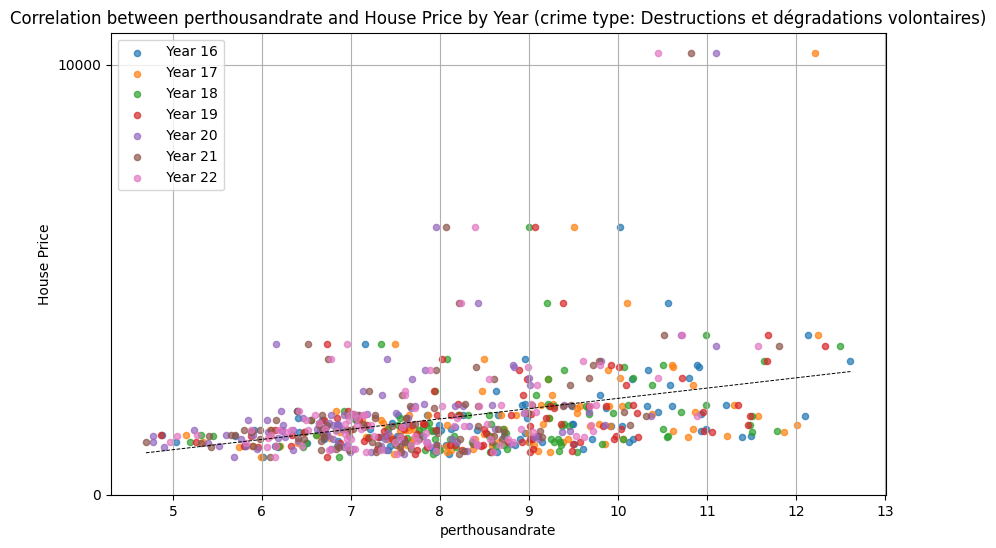

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


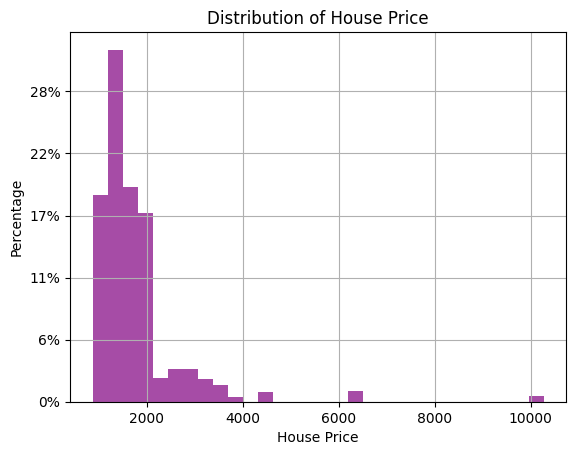

In [30]:
def scatter_plot_occurrences(feature, start_interval, interval, crime_type):
    filtered_data_plot = merged_data_info_ville[merged_data_info_ville["crime type"] == crime_type]
    
    plt.figure(figsize=(10, 6))
    
    #iterate through the unique years and plot data points with different colors
    for year in sorted(filtered_data_plot["year"].unique()):
        year_data = filtered_data_plot[filtered_data_plot["year"] == year]
        occurrences = year_data["perthousandrate"]
        feat = year_data[feature]
        label = f" Year {year}"
        plt.scatter(occurrences, feat, alpha=0.7, label=label,s=20)

    #add a deashed regression line for all data points  
    all_data = pd.concat([year_data for _, year_data in filtered_data_plot.groupby("year")])
    occurrences = all_data["perthousandrate"]
    feat = all_data[feature]
    sns.regplot(x=occurrences, y=feat, data=all_data, scatter=False, color='black',ci=None, line_kws={"linestyle": "--","linewidth": 0.7})

    plt.title(f"Correlation between perthousandrate and {feature} by Year (crime type: {crime_type})")
    plt.xlabel("perthousandrate")
    plt.ylabel(feature)
    plt.yticks(range(start_interval, int(max(feat)) + 1, interval))
    plt.grid(True)
    plt.legend()
    
    plt.show()

def plot_distribution(feature): 
    plt.hist(merged_data_info_ville[feature], bins=30, color='purple', alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Percentage')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100 / len(merged_data_info_ville[feature])) for x in plt.gca().get_yticks()])
    plt.grid(True)
    plt.show()

scatter_plot_occurrences( "House Price",0,10000,"Destructions et dégradations volontaires") #example
plot_distribution("House Price") #example

The third function is designed to calculate and save the correlation between several specific features and the "perthousandrate" for a specific crime type. This function will be useful in a later chapter, when we will analyze various aspects of these features in greater detail.

In [11]:
def feature_correlations(cryme_type): 
    unique_feature = ['Area', 'Population Density', 'Active Population', 'Unemployment Rate', 'Average Income', 'House Price']
    correlations=[]
    vols = merged_data_info_ville[merged_data_info_ville['crime type'] == cryme_type]
    rate = vols["perthousandrate"]

    for feature in unique_feature:
        if feature != 'perthousandrate':
            
            current_feature = vols[feature]
            correlation = np.corrcoef(rate, current_feature)[0, 1]
            correlations.append((feature, correlation))
        
    sorted_correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

    result_df = pd.DataFrame(sorted_correlations, columns=['Feature', 'Correlation'])
    result_df.index = result_df.index + 1    #add an index column starting from 1

    return result_df

In [12]:
feature_correlations("Vols avec armes") #example

,Feature,Correlation
1,House Price,0.654297
2,Population Density,0.559669
3,Active Population,0.465586
4,Unemployment Rate,0.424372
5,Average Income,0.401525
6,Area,-0.474577


#### Heatmaps 
To make visualisation more effective, heatmaps have been created. 

To create the **Geographical Heatmap** , a GeoJSON file was required. 

GeoJSON is an open standard format for encoding geographic data structures using JSON (JavaScript Object Notation). It is commonly used to represent geographical features, such as points, lines, polygons, and their associated properties. In our case, departments are described as polygons. <br>

In this file we find a JSON object that contains an array of features, used because multiple geographical features are represented together. 

GeoJSON files containts two main features:
Geometry: The "geometry" field in a GeoJSON feature specifies the type of geographical shape the feature represents (e.g., "Point," "LineString," "Polygon," etc.). The coordinates associated with the geometry define the shape's spatial location. For example, for a "Point," it's a single set of coordinates; for a "Polygon," it's an array of coordinates. <br> 
Properties:The "properties" field in a GeoJSON feature contains a JSON object with additional attributes or properties associated with the feature. These properties can include any relevant information, such as names, identifiers, or values. In this case, we have the name of the departments.  (3,4)

For Geographical Heatmap (create_france_heatmap function) the code follows this logic:

- The dataset filtered_df is created by filtering the merged_data_info_ville DataFrame for a specific crime type and year.
- Format adjustments are made for certain department names, replacing special characters for proper display.
- Geographic data (merged_data) is merged with the filtered DataFrame, matching department names.
- A Folium map (m) centered on France is created.
- A choropleth layer (folium.Choropleth) is added to the map, using the merged geographic and crime data. It assigns colors based on the number of cases ("occurrences") in each department.
The map is saved as an HTML file named "heatmap.html," and a message is printed to confirm the save.

In [13]:
def create_france_heatmap(anno, crime_type): 

    filtered_df = merged_data_info_ville[(merged_data_info_ville['crime type'] == crime_type) & (merged_data_info_ville['year'] == anno)]  
    #format adjustment
    row_index = filtered_df.index[filtered_df['Department'] == "Côtes-d'Armor"].tolist()[0] 
    new_value = "C\u00f4tes-d'Armor" 
    filtered_df.at[row_index, 'Department'] = new_value 
    row_index = filtered_df.index[filtered_df['Department'] == "Côte-d'Or"].tolist()[0]  
    new_value2 = "C\u00f4te-d'Or"  
    filtered_df.at[row_index, 'Department'] = new_value2 

    merged_data = gdf.merge(filtered_df, left_on='nom', right_on='Department', how='inner')
    
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)  # map on france
    #adding data
    folium.Choropleth(
        geo_data=merged_data, 
        name='choropleth', 
        data=merged_data, 
        columns=['LIBGEO', 'perthousandrate'], 
        key_on='feature.properties.nom', 
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f'{crime_type} Cases in {anno}'
    ).add_to(m)
    m.save("heatmap.html")
    print("The geographic heatmap has been saved in the folder")
    return m

create_france_heatmap(16,'Vols de véhicules') #example


The geographic heatmap has been saved in the folder


### MACHINE LEARNING MODELS

#### Outliers

The primary objective of this project is to train a machine learning model using the complete dataset for predicting crimes. However, before proceeding with this task, an essential step is performed to enhance the model's accuracy: outlier management. <br> 
The outlier function calculates the lower and upper limits for identifying outliers in each crime type, considering the "perthousandrate" column. <br>
The function finds and removes outliers for each crime type separately by grouping the data by the "crime type" column and then calculating the outliers for each group.

In [14]:
def outliers(df):
    print(len(df))
    
    non_outliers_df = pd.DataFrame()
    
    grouped = df.groupby('crime type')
    
    for crime_type, group_df in grouped: #group_df represents each of the subsets or groups, the DataFrame that contains only the rows that belong to the current group being processed in the loop
        Q1 = group_df['perthousandrate'].quantile(0.25) 
        Q3 = group_df['perthousandrate'].quantile(0.75) 

        IQR = Q3 - Q1  #interquartile range (IQR)

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        non_outliers_group = group_df[(group_df['perthousandrate'] >= lower_limit) & (group_df['perthousandrate'] <= upper_limit)] #filter the outliers for the current "crime type" group

        non_outliers_df = pd.concat([non_outliers_df, non_outliers_group]) #append the non-outliers to the result DataFrame
    
    print(len(non_outliers_df))
    return non_outliers_df


In [15]:
merged_data_info_ville = outliers(merged_data_info_ville)
merged_data_info_ville.head()

9408
9024


,CODGEO,LIBGEO,NB_COM,crime type,year,Departement code,Region code,unit,millPOP,millLOG,...,LOG,perthousandrate,Department,Population,Area,Population Density,Active Population,Unemployment Rate,Average Income,House Price
14,01,Ain,392,Autres coups et blessures volontaires,16,01,84,victime,16,16,...,"308491,1600513844",1.107413,Ain,654869,5749,114,48.4,4.8,23598,1941
15,01,Ain,392,Autres coups et blessures volontaires,17,01,84,victime,17,17,...,"313061,4522700008",1.227947,Ain,654869,5749,114,48.4,4.8,23598,1941
16,01,Ain,392,Autres coups et blessures volontaires,18,01,84,victime,18,18,...,"317983,0764471052",1.247618,Ain,654869,5749,114,48.4,4.8,23598,1941
17,01,Ain,392,Autres coups et blessures volontaires,19,01,84,victime,19,19,...,"321432,1284726467",1.270631,Ain,654869,5749,114,48.4,4.8,23598,1941
18,01,Ain,392,Autres coups et blessures volontaires,20,01,84,victime,20,20,...,"325430,9391892830",1.176549,Ain,654869,5749,114,48.4,4.8,23598,1941


### Random Forest

Two main algorithm will be used in this project, Random Forest and XGBoost.

Starting from Random Forest, it is a powerful machine learning algorithm that has gained popularity for its efficacy in predicting continuous outcomes, making it particularly suitable for crime analysis. It is an ensemble learning method that combines multiple decision trees to enhance prediction accuracy and robustness. <br>

Random Forest starts by creating multiple subsets of the training data through a process called bagging. With this process, for each subset, data points are randomly selected from the training set. Some data points may be included multiple times, while others may be left out.
For each subset, a decision tree is constructed: these structures recursively split the data based on feature values to make predictions. <br>
Each tree is built using a random subset of features at each split node. <br>
After constructing multiple decision trees, predictions are made for each data point in the test set using each tree. In our case, these predictions will be numerical values representing crime rates. <br>
To obtain the final prediction for a data point, the individual predictions from all the decision trees are aggregated. In our case, this means taking the average of the predictions. 

This model presents interesting advantages. First of all, the ensemble learning: multiple decision trees create a more accurate and stable model. This model maintains the Decison Tree advantage of the low bias (where bias is the error introduced by approximating a real-word problem, which may be complex, by a simplifed model). Moreover, it is capable to overcome one of the problems of Decision trees, for example overfitting. In particular this is possible thanks to bagging. Indeed, since bagging consist in randomly selecting subsets of the training data, it allows each tree to be trained on a different dataset. This diversity among trees helps to capture different aspects of the underlying patterns in the data. It allows the model to reduce variance (the model sensitivity to fluctuations) and so, to reduce their risk to capture noise rather than the true signal. 
Morover, as said, in Random Forest there is a Randomization fature: during each tree's construction, a random subset of the features is considered at each split point. This randomness reduces the risk of trees being dominated by a single feature and increases the model's generalization capacity. (5,6)

**Methodology:** <br>

- Data Encoding: To prepare the data for modeling, label encoding was used to transform the categorical "crime type" variable into a numeric format. This results in the creation of a new feature, "crime_type_encoded", which is essential for training the Random Forest model. 

- Feature Selection: The selection of relevant features in this model was a deliberate process. We considered various factors that could influence crime rates, such as socio-economic and demographic indicators. <br> While "Population" is undoubtedly a critical factor in understanding the dynamics of crime, we made a decision not to include it as a separate feature in the model. Instead, we decided to predict the "perthousandrate". In this way, "Population" is already a key component of the predicted values. The "perthousandrate" is a metric that quantifies the number of recorded delinquency incidents ('occurrences') per thousand inhabitants within the municipality of occurrence. As such, it inherently accounts for the population factor. Including 'Population' as a separate feature in the model would risk introducing multicollinearity, a situation where predictor variables are highly correlated. Multicollinearity can lead to unstable coefficient estimates and make it challenging to interpret the individual contributions of each feature. <br> This decision allows us to focus on the other selected features' unique contributions to crime rates, providing a more interpretable and robust model. <br> The model considers these features: "crime_type_encoded", "Area", "Population Density", "Active Population", "Unemployment Rate", "Average Income", and "House Price".

- Data Splitting and Training. 
<br>

**Hyperparameters and Tuning**

The performance of a Machine Leaning algorithm can be significantly influenced by hyperparameters. Hyperparameters are settings that are not learned from the data but must be predefined before training the model. In our case, we set hyperparameters such as the number of trees (n_estimators), maximum tree depth (max_depth), minimum samples for node split (min_samples_split), and minimum samples for leaf node (min_samples_leaf).

The choice of hyperparameters can impact the model's accuracy and generalization ability. It's essential to find the right combination of hyperparameters that suits each specific prediction task. This process is known as hyperparameter tuning, and it plays a crucial role in optimizing model performance. Hyperparameter tuning involves systematically searching through different hyperparameter values or ranges to identify the configuration that results in the best model performance. Since this process is compute-intensive, it will be done only for the XGBoost model, which appeared to be the best from a first analysis. (24)

In this Random Forest model, the hyperparameters are set as follows:
- Number of Trees (n_estimators): 100
- Maximum Tree Depth (max_depth): Unrestricted
- Minimum Samples for Node Split (min_samples_split): 2 <br> This hyperparameter represent the minimum number of data points required in a node for it to be further split into child nodes during the tree-building process. If a node contains fewer data points than the specified min_samples_split, it will not be split and it becomes a leaf node.
- Minimum Samples for Leaf Node (min_samples_leaf): 1 <br> This hyperparameter sets the minimum number of data points required to create a leaf node (terminal node) in the decision tree. When a node is being split, if one of the resulting child nodes would contain fewer data points than min_samples_leaf, the split is canceled, and the node becomes a leaf node. (7)
- Random Seed (random_state): 42 for reproducibility 

**Model Evaluation** <br>
To evaluate the model, the performance is assessed using the Mean Squared Error (MSE) metric. This metric quantifies the model's ability to predict continuous outcomes, making it highly suitable for our regression problem. <br>
The formula for MSE is as follows:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2\ $$

Where:
- $n$ represents the number of data points.
- $ y_i $ is the actual observed crime rate for the $i$-th data point.
- $ ŷ_i $ is the predicted crime rate for the $i$-th data point.

This metric was chosen beacuse it's very sensitive to large errors, and so it's useful for regression tasks and crime prediction, where the magnitude of the deviation is crucial. <br>
Moreover, this metric is differentiable, this property is necessary for grandient descent used in XGBoost, an algorithm that will be implemented later. In addition, this metric is simple and easy to understand. (8)<br>
A baseline comparison is also performed, where the crime rates is predicted using the mean value of the training data. 

In [16]:
def splitted_datasets():
    #enconding
    label_encoder = LabelEncoder() 
    merged_data_info_ville.loc[:,'crime_type_encoded'] = label_encoder.fit_transform(merged_data_info_ville['crime type']) 
    
    #splitting
    X = merged_data_info_ville[['crime_type_encoded','Area','Population Density', 'Active Population', 'Unemployment Rate', 'Average Income','House Price']]
    y =  merged_data_info_ville[ 'perthousandrate']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [17]:
def randomforest_model():

    X_train, X_test, y_train, y_test = splitted_datasets()
    
    rf_regressor = RandomForestRegressor(
        n_estimators=100,        #number of trees in the forest
        max_depth=None,           #maximum depth of the tree
        min_samples_split=2,      #minimum number of samples required to split an internal node
        min_samples_leaf=1,       #minimum number of samples required to be at a leaf node
        random_state=42           #random seed for reproducibility
    )
   
    rf_regressor.fit(X_train, y_train) #fit the model to the training data
    y_pred = rf_regressor.predict(X_test) #predict on the test data
    mse = mean_squared_error(y_test, y_pred) #evaluate the model 

    #baseline comparison 
    baseline_prediction = y_train.mean()
    baseline_predictions = np.full_like(y_test, baseline_prediction) 
    baseline_mse = mean_squared_error(y_test, baseline_predictions)  #Mean Squared Error (MSE) for the baseline model
    
    
    print(f"Mean Squared Error RandomForest: {mse}") 
    print(f"Mean Squared Error (Baseline): {baseline_mse}")

randomforest_model()

Mean Squared Error RandomForest: 0.3227605996265624
Mean Squared Error (Baseline): 6.548237532990251


### XGBoost, General model

XGBoost is another ensemble learning method that combines the predictions of multiple decision trees, mitigating their individual weaknesses and enhancing overall predictive performance.

XGBoost employs an ensemble of decision trees to make accurate predictions, just like Random Forest. In this case, each tree is trained sequentially and not in parallel. This allows each tree to correct the errors made by the previous ones.<br>
The traning of this trees is designed to minimize a specific loss function, which is defined based on the regression objective, in our case the loss-function to minimize will be the Mean Square Error. A gradient descent algorithm is used to update the model's parameters at each iteration. (8,9) This gradient boosting approach iteratively refines the model by fitting new decision trees to the residuals of the previous ones.

In summary, this model harnesses the power of boosting (subsequential training), combining multiple decision trees to create a more accurate and robust predictive model. XGBoost, much like Random Forest produce highly accurate predictions, retaining the benefits of decision trees, such as low bias and low variance. <br>
Moreover, similar to Random Forest, XGBoost introduces randomness into the modeling process: during the construction of each decision tree, a random subset of features is considered at each split point. (10)

The **Methodology** for this model is the same used for the Random Forest Model.

Initially, the **Hyperparameters** are set as follows:
- Number of Trees (n_estimators): 100
- Maximum Tree Depth (max_depth): Unrestricted
- Minimum Child Weight (min_child_weight): 2 <br> Specifies the minimum sum of instance weights required in each child node when splitting a tree node during the construction of the tree. <br> Indeed, each data point in the training dataset is assigned a weight. These weights are typically used to indicate the importance or significance of each instance in the learning process. <br> If, during the tree construction, the sum of instance weights falls below the specified min_child_weight, the split is not allowed, and the node becomes a leaf node. This ensures that the child nodes have a minimum amount of information to be considered for further splitting. (10)
- Random Seed (random_state): 42 

The model performance is again **evaluated** using the Mean Squared Error (MSE) metric and a baseline comparison is conducted.

This section presents the XGBoost modeling approach for predicting crime rates, which involves two distinct strategies.
The first strategy trains a single XGBoost model using the "crime type" variable as a feature, while the second strategy creates individual models for each unique class, filtering the dataset accordingly.

In [18]:
def XGBoost_general_model():
    
    X_train, X_test, y_train, y_test = splitted_datasets()

    xgb_regressor = xgb.XGBRegressor(
        n_estimators=100,      #number of trees 
        min_child_weight=2,   #min_samples_split=2, minimum number of samples required to split an internal node
        random_state=42        
    )

    xgb_regressor.fit(X_train, y_train)
    y_pred = xgb_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred) 

    #baseline comparison
    baseline_prediction = y_train.mean()
    baseline_predictions = np.full_like(y_test, baseline_prediction)
    baseline_mse = mean_squared_error(y_test, baseline_predictions)

    print(f"Mean Squared Error XGBoost: {mse}")
    print(f"Mean Squared Error (Baseline): {baseline_mse}")
    
XGBoost_general_model()

Mean Squared Error XGBoost: 0.32190226801239846
Mean Squared Error (Baseline): 6.548237532990251


#### XGBoost general model: Hyperparameters tuning 

The next section will deal with the process of hyperparameter tuning for the XGBoost model, a critical step to optimize its performance. 
 

**GridSearchCV** <br>
The exploration involves GridSearchCV, a tool within the scikit-learn library, to search for the optimal hyperparameter combination.This method automates what would be a time-consuming manual exploration. <br> 

There are several reasons why GridSearchCV is commonly chosen for hyperparameter tuning: 
<li> Systematic Search and Clearity : GridSearchCV performs a systematic search over a predefined set of hyperparameters. It allows to specify a range of hyperparameter values or discrete choices for each hyperparameter, and it explores all possible combinations. 
<li> Cross-Validation: GridSearchCV combines hyperparameter tuning with cross-validation. It divides the training data into multiple folds and trains the model on different subsets of the data, providing a robust estimate of model performance. This helps prevent overfitting.
<li> Objective Evaluation: GridSearchCV uses a scoring metric (in our cas Mean Squared Error) to evaluate the model's performance for each set of hyperparameters. This objective evaluation helps you identify the best hyperparameter combination based on a specific criterion.
<li> Reproducibility: GridSearchCV ensures reproducibility of results. When we specify a set of hyperparameters and run GridSearchCV with the same data and random seed, we obtain the same results, making experiments more reproducible.
<li> Best Practices: GridSearchCV is considered a best practice in machine learning for systematically optimizing hyperparameters. It helps to find a good balance between model complexity and generalization. (11,12,13,14)

**Tuned Hyperparameters** <br>
The focus will be on 3 key hyperparameters: 

1. 'n_estimators': governs the number of decision trees, or estimators, within the ensemble. The choice of 'n_estimators' significantly influences the model's predictive capacity and generalization.

2. 'colsample_bylevel': dictates the fraction of features to consider when constructing each tree level. Tuning this parameter allows to find balance between model complexity and predictive power.

3. 'min_child_weight': decides the minimum sum of instance weight required in a child.

In summary, the grid search process assesses different configurations of 'n_estimators,' 'colsample_bylevel,' and 'min_child_weight.' <br>Each combination is subjected to evaluation using a specified scoring metric, in this case the Mean Squared Error (MSE). The hyperparameter values that presents the lowest MSE will be considered the optimal configuration for the model.

In [19]:
def XGBoost_general_model_tuning():

    X_train, X_test, y_train, y_test = splitted_datasets()
    xgb_model = xgb.XGBRegressor() 

    #define the hyperparameters and their possible values
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'min_child_weight': [1, 2,3],  
        'colsample_bylevel': [0.5, 0.8, 1],
        'random_state': [42]  #include random_state for reproducibility 
            }

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10) 

    grid_search.fit(X_train, y_train) #fit the GridSearchCV object to the training data

    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best GridSearchCV Score: ", -grid_search.best_score_)
    
    best_general_model = grid_search.best_estimator_ #an istance of the XGBRegressor(), trained with the best combination of hyperparameters

    y_pred = best_general_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error of the best model: {mse}")

    return best_general_model


best_general_model = XGBoost_general_model_tuning()
%time

Best Hyperparameters:  {'colsample_bylevel': 1, 'min_child_weight': 3, 'n_estimators': 100, 'random_state': 42}
Best GridSearchCV Score:  0.3257682583677882
Mean Squared Error of the best model: 0.320238997518666
CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 14.3 µs


**Results** <br>
The hyperparameter tuning identified a model configuration with a lower Mean Squared Error (MSE) when compared to the initial model, the one crafted without tuning.

- Mean Squared Error XGBoost initial model (without tuning): $3.219 \times 10^{-1}$ <br>
    Hyperparameters: {'min_child_weight': 2, 'n_estimators': 100, 'random_state': 42}
    
- Mean Squared Error of the best model: $3.202 \times 10^{-1}$ <br>
    Best Hyperparameters: {'colsample_bylevel': 1, 'min_child_weight': 3, 'n_estimators': 100, 'random_state': 42}

### XGBoost, Class-Specific Models

The analysis will continue considering the second strategy for the XGBoost model. In this case, the idea is to create as much models as the number of different crime types. They will all be trained with different datasets, filtered by class.

To train separate XGBoost models for each class, these steps will be followed:

<li>Identify unique crime types. 
<li>Iterate through crime types: for each unique class label, create a separate dataset with only instances of that class.
<li>Train XGBoost models: train a separate XGBoost model for each class-specific dataset.

In [20]:
def XGBoost_specific_model():  
    
    unique_crime_types = merged_data_info_ville['crime type'].unique() # Step 1: Identify Unique crime types
    mse_results = []
    # Step 2: Iterate Through crime types
    for class_label in unique_crime_types:
        
        class_data = merged_data_info_ville[merged_data_info_ville['crime type'] == class_label] # Create a dataset for the specific class

        X_class = class_data[[ 'Area', 'Population Density', 'Active Population', 'Unemployment Rate', 'Average Income', 'House Price']]
        y_class = class_data['perthousandrate']

        X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

        # Step 3: Train XGBoost Model for each class
        xgb_regressor = xgb.XGBRegressor(
            n_estimators=100,
            min_child_weight=2,
            random_state=42
        )

        xgb_regressor.fit(X_train_class, y_train_class)
        y_pred_class = xgb_regressor.predict(X_test_class)
        mse_class = mean_squared_error(y_test_class, y_pred_class)
        mse_results.append({
            'crime type': class_label,
            'MSE': mse_class
        })

    mse_df = pd.DataFrame(mse_results)
    mse_dataframe_sorted = mse_df.sort_values(by='MSE')
    return  mse_dataframe_sorted
XGBoost_specific_model()  

,crime type,MSE
8,Vols avec armes,0.000257
13,Vols violents sans arme,0.013388
5,Trafic de stupéfiants,0.013822
7,Violences sexuelles,0.069588
0,Autres coups et blessures volontaires,0.070432
11,Vols de véhicules,0.084655
9,Vols d'accessoires sur véhicules,0.089768
3,Coups et blessures volontaires intrafamiliaux,0.222677
6,Usage de stupéfiants,0.268681
10,Vols dans les véhicules,0.304122


#### XGBoost, Class-Specific Model: Hyperparamters Tuning

From the evaluation of the MSEs, it's possible to see that the best Class-Specific Model is the one for the crime type "Vols avec armes" (armed robberies). <br>Mean Squared Error: $2.570 \times 10^{-4}$ <br>
The next section will deal with the hyperparamters tuning for this specific model.

In [21]:
def vols_avec_armes_datasets():

    class_data = merged_data_info_ville[merged_data_info_ville['crime type'] == 'Vols avec armes']

    X_class= class_data[[ 'Area', 'Population Density', 'Active Population', 'Unemployment Rate', 'Average Income', 'House Price']]
    y_class = class_data['perthousandrate']

    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, train_size=0.8, random_state=42)
    
    return X_train_class, X_test_class, y_train_class, y_test_class 

In [22]:
def XGBoost_specific_model_tuning():  
        
        X_train_class, X_test_class, y_train_class, y_test_class = vols_avec_armes_datasets()
        xgb_model = xgb.XGBRegressor()

        #define the hyperparameters and their possible values for tuning
        param_grid = {
                'n_estimators': [100,500,1000], 
                'colsample_bylevel': [0.5, 0.8, 1],
                'min_child_weight': [1,2,3],  
                'random_state': [42]  #for reproducibility 
        }

        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
        grid_search.fit(X_train_class, y_train_class)

        best_specific_model = grid_search.best_estimator_
        best_specific_params = grid_search.best_params_
        print(f"Best Hyperparameters :{ best_specific_params}")
        best_mse_for_class=-grid_search.best_score_
        print(f"Best GridSearchCV Score : {best_mse_for_class}")


        y_pred_best_class = best_specific_model .predict(X_test_class)
        mse_class = mean_squared_error(y_test_class, y_pred_best_class)

        print(f"Best Mean Squared Error: {mse_class}")

        return best_specific_model

best_specific_model = XGBoost_specific_model_tuning()
%time

Best Hyperparameters :{'colsample_bylevel': 0.8, 'min_child_weight': 3, 'n_estimators': 1000, 'random_state': 42}
Best GridSearchCV Score : 0.0003874207181691528
Best Mean Squared Error: 0.0002580302238449278
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


It's notable that the Best Model found by GridSearchCV presents a slightly higher Mean Squared Error ($2.58 \times 10^{-4}$) compared to the model that we trained previously, before the tuning process (initial model Mean Squared Error: $2.57 \times 10^{-4}$). 

This may initially appear surprising, as it suggests that the Best Model identified through the tuning process may not be strictly better in terms of test set performance.

However, we can explain this observation considering the way in which GridSearchCV selects the best model. <br>
GridSearchCV selects the best-performing model based on the GridSearchCV score. This value is the average MSE calculated through internal cross-validation, done only on the training dataset. This average MSE is given by grid_search.best_score_. 
In this specific case, the best model obtained from hyperparameter tuning may a lower grid search score (grid_search.best_score_) compared to the initial model (which indicates better performance according to GridSearchCV's internal cross-validation on the training set), and so it was choosen by  GridSearchCV as the best model. However, this doesn't mean that it performs better even with the test dataset. Indeed, it has a higher Mean Squared Error when we assess the model's performance using the test dataset (y_pred = best_general_model.predict(X_test)). 

To further solidify this explaination, we will calculate the GridSearchCV MSE Score for the initial model.

In [23]:
def XGBoost_initial_model_GridSearch():  
        
        X_train_class, X_test_class, y_train_class, y_test_class = vols_avec_armes_datasets()
        xgb_model = xgb.XGBRegressor()

        #define the hyperparameters and their possible values for tuning
        param_grid = {
                'n_estimators': [100], 
                'min_child_weight': [2],  
                'random_state': [42]  #for reproducibility 
        }

        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
        grid_search.fit(X_train_class, y_train_class)

        best_specific_model = grid_search.best_estimator_
        best_specific_params = grid_search.best_params_
        print(f"Initial model Hyperparameters :{ best_specific_params}")
        best_mse_for_class=-grid_search.best_score_
        print(f"Initial model GridSearchCV MSE Score : {best_mse_for_class}")


        y_pred_best_class = best_specific_model .predict(X_test_class)
        mse_class = mean_squared_error(y_test_class, y_pred_best_class)

        print(f"Initial model Mean Squared Error: {mse_class}")

XGBoost_initial_model_GridSearch()

Initial model Hyperparameters :{'min_child_weight': 2, 'n_estimators': 100, 'random_state': 42}
Initial model GridSearchCV MSE Score : 0.0003905368241843645
Initial model Mean Squared Error: 0.00025709077163151164


**Results** <br>

As axpected , the best model obtained from hyperparameter tuning has a lower grid search score (grid_search.best_score_) compared to the initial model (indicating better performances according to GridSearchCV's internal cross-validation on the train set). When assessing the model's performance on the test set using the test dataset (y_pred = best_general_model.predict(X_test)), the best model has a slightly higher MSE than the initial model.

In summary,

- Initial Class-specific Model:  <br>
Initial model Hyperparameters: {'min_child_weight': 2, 'n_estimators': 100, 'random_state': 42} <br>
Initial model GridSearchCV Score: $3.9054 \times 10^{-4}$ (worst) <br>
Initial model Mean Squared Error: $2.5709 \times 10^{-4}$ (better)<br>

- Best  Class-specific Model: <br>
Best model Hyperparameters: {'colsample_bylevel': 0.8, 'min_child_weight': 3, 'n_estimators': 1000, 'random_state': 42} <br>
Best model GridSearchCV Score: $3.8742 \times 10^{-4}$ <br>
Best model Mean Squared Error: $2.5803 \times 10^{-4}$ <br>

In conclusion, the Best model, even though it presents a higher MSE on the test set, is choosen by GridSearchCV because it exhibits a lower GridSearchCV Score (during the cross-validation process on the train test).
This outcome underscores the significance of our choice of evaluation metrics in determining the best model as it emphasizes the importance of considering both internal cross-validation performance and external test set performance when assessing model performance and suitability. The difference in MSE between these models is very low, indicating that the tuned model remains the best one for its performance.

### Comparison Between Class-Specific and General Model

In order to determine the superior model between best the General and best Class-Specific models, a final comparative analysis will be conducted. The best models will be both valuated for their ability to predict crime occurrences of the crime type "Vols avec armes" (armed robberies). <br>

This **procedure** will be followed:
<li>Data Selection: filtering data related to the specific crime class of interest.<br>
<li>Fature Sets: two distinct feature sets are created for modeling. The second feature set is required because the general model needs also the feature "crime_type_encoded".<br>

For both models, predictions are generated on the testing dataset. The **performance** is assessed using the Mean Squared Error (MSE).

In essence, the Class-Specific Model is trained exclusively on the feature set X_class_specific, while the General model utilizes the feature set X_class_general and is trained to predict occurrences of all crime crime types.<br>

In [24]:
def compare_model():
    
    class_data = merged_data_info_ville[merged_data_info_ville['crime type'] == 'Vols avec armes']

    X_class_specific = class_data[[ 'Area', 'Population Density', 'Active Population', 'Unemployment Rate', 'Average Income', 'House Price']]
    X_class_general = class_data[['crime_type_encoded', 'Area', 'Population Density', 'Active Population', 'Unemployment Rate', 'Average Income', 'House Price']]
    
    y_class = class_data['perthousandrate']

    X_train_class_s, X_test_class_s, y_train_class, y_test_class = train_test_split(X_class_specific, y_class, test_size=0.2, train_size=0.8, random_state=42)
    X_train_class_g, X_test_class_g, y_train_class, y_test_class = train_test_split(X_class_general, y_class, test_size=0.2, train_size=0.8, random_state=42)

    y_pred_specific = best_specific_model.predict(X_test_class_s)
    mse_specific = mean_squared_error(y_test_class, y_pred_specific) 

    y_pred_general = best_general_model.predict(X_test_class_g)
    mse_general = mean_squared_error(y_test_class, y_pred_general) 

    print(f"Mean Squared Error Specific: {mse_specific}")
    print(f"Mean Squared Error General: {mse_general}")


compare_model()

Mean Squared Error Specific: 0.0002580302238449278
Mean Squared Error General: 0.001720694746212812


**Results:**<br>

- Class-Specific Model: <br>
Mean Squared Error: $2.5803 \times 10^{-4}$
- General Model: <br>
Mean Squared Error: $1.7207 \times 10^{-3}$


The results indicate a clear distinction in performance between the two models: the model trained exclusively for predicting "Vols avec armes" (armed robberies) exhibits a remarkable Mean Squared Error of $2.5803 \times 10^{-4}$, highlighting its precision in forecasting this specific type of crime. 
In contrast, the general model, designed to predict occurrences across all crime crime types, exhibits a considerably higher MSE of $1.7207 \times 10^{-3}$ for the this crime type.

This is not surpsing, this superiority can be attributed to several factors. The first one is Model Complexity, the General Model is designed to predict occurrences across all crime types, which makes it a more complex model. Indeed, it needs to consider a broader range of patterns and relationships between features and the target variable. In contrast, the specific model is tailored to a single crime type, allowing it to capture finer details specific to that crime type. (25) <br>
Another reason can be Feature Relevance, certain features may have a stronger impact on predicting specific crime types. The Class-Specific Model can emphasize the importance of features that are particularly relevant to the crime type it is designed for. In contrast, the General Model may distribute its importance across a wider range of features, potentially decreasing the predictive power of those most relevant to a specific crime type.

In conclusion, these outcomes highlight the significance of employing class-specific models for crime prediction tasks, the class-specific model demonstrated its ability to capture patterns associated with the "Vols avec armes"(armed robberies) class.

Law enforcement agencies can adopt class-specific models to enhance crime prevention and resource allocation. By focusing on individual crime categories, authorities can allocate resources more efficiently and interventions to address specific criminal activities. In conclusion, this section has shown the efficacy of class-specific machine learning models in crime prediction. 

# Explainability Analysis with SHAP

SHAP is a powerful and widely used framework that allows to understand the contribution of each feature to a model's prediction.It's useful to understand features importance and to guide feature selection. 

In the next section, SHAP will be used for finding insights into the global beahviour of the model.

The model that will be investigated will be the superior model, the Class-Specific model setted with the best hyperparameters. <br>
To do this, an Explainer will be created: in this context, an Explainer is an object to analyse the prediction made by the model. Different types of explainer are present in the library.
Explainer class is a superset of TreeExplainer, the one that fits with our XGBoost model. For this reason, if we create an Explainer, the model automatically selects the TreeExplainer as the appropriate method for interpretation, as it recognises a tree model. <br>
The Explainer is created by taking as argument a trained model, in our case the best_specific_model. 
Then, the Explainer calculates the contribution of each feature to the prediction, thanks to its method 'shap_values'. 

This method allows us to measure the contribution of features, by finding SHAP values. SHAP values represent the contribution of each feature to the prediction made by the model for each instance in the dataset passed as parameter. In this case the entire X_class dataset is passed as paramter. This decision was made to obtain a global interpretation. <br>
Since SHAP values are not calculated on a per-sample basis but rather aim to provide a global interpretation of how each feature affects model predictions, by passing the entire dataset we will obtain a holistic view of feature importance. <br>
Morevore, the use of the entire dataset allows us to obtain statistical significance. Indeed, SHAP will consider the overall distribution of data points and their variations, offering robust and complete interpretations.

As said, SHAP values quantify how the presence or absence of a feature influence the model prodections. <br>
They are calculated using perturbed datasets. Multiple datasets are generated with different combinations of features presence and absence and then, with each dataset, predictions are made. For each feature, the tool compares the predictions made with the feature with the prediction made witout it. 
This process is don for a subset of the dataset passaed as paramter. For each feature and each entry of the subset, a contribution score is calculated. This creates a matrix (shap_values) which will contain the contribution of each feature for each datapoint of the subset.
Finally, the SHAP value for a feature will be the average of the contribution scores of that feature. (15,16,17)

In [25]:
def shap_analysis():
    
    class_data = merged_data_info_ville[merged_data_info_ville['crime type'] == 'Vols avec armes']
    X_class= class_data[['Area', 'Population Density', 'Active Population', 'Unemployment Rate', 'Average Income', 'House Price']]
    
    explainer = shap.Explainer(best_specific_model)
    shap_values = explainer.shap_values(X_class)

    return shap_values, X_class

### Bar Plot: absolute SHAP values

Explainers come with visualistions tools. Bar Plot is the first one that we are going to analyise.

In this representation, features are ordered by importance, making it easy to discern their individual impact. All SHAP values are shown, offering an intuitive view of each feature contribution to the model's predictions. <br>
It's important to notice that the graph represents absolute SHAP values, and so it's impartial to whether a feature exerts a positive or negative effect on predictions. 

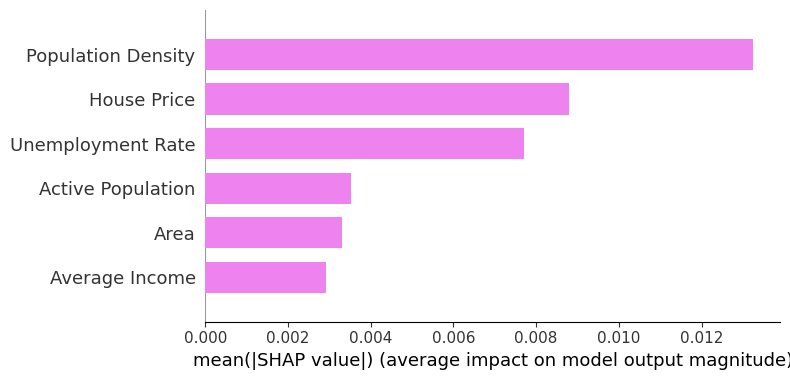

In [26]:
def shap_analysis_bp_plot():
    shap_values, X_class=shap_analysis()
    shap.summary_plot(shap_values, X_class, plot_type="bar", color='violet')

shap_analysis_bp_plot()

The population density emerges as the dominant factor shaping the model's predictions.

An important observation is that "Average Income" plays a minor role on the predictions, while "House Price" emerge as a determinant. This observation highlights that the driving force behind the model's predictions lies not in the average salary but rather in the cost of living.

However, it's possible to make more meaningful obseravtions by using another type of plot, the Beeswarm Plots.

### Beeswarm Plot: a More Complete Portrayal

This representation gives an more complete overview of feature importance. Fatures will be always be ordered by importance. <br>
A single dot represents a single observation, a single entry in the subset of X_class used by SHAP.

The orizontal axis is the SHAP value and the color indicates if the value of that feature in that observation is high or low. This graph it's very useful to highlight the magnitude and the direction of the contribution of each feature. (18)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


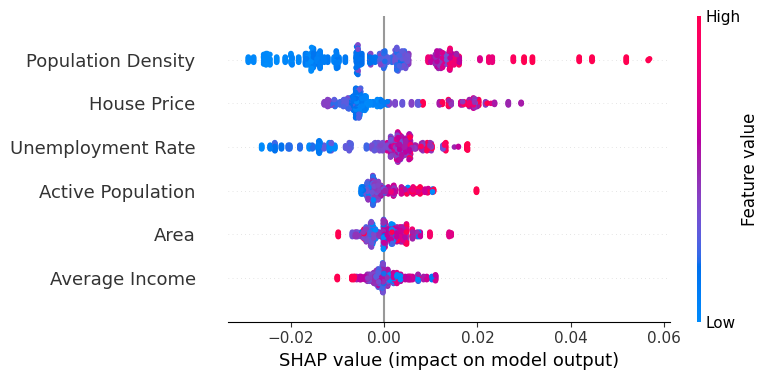

In [27]:
def shap_analysis_summary_plot():
    shap_values, X_class=shap_analysis()
    shap.summary_plot (shap_values, X_class)

shap_analysis_summary_plot()

### Feature Analysis

In this comprehensive chapter, we embark on an exploration of feature characteristics and their impact on predicting armed robbery rates. Our objective is to discern whether insights gained from traditional correlation analysis align with those obtained through SHAP.

We will focus on the six features: "Average Income", "Population Density", "House Price", "Unemployment Rate", "Active Population" and "Area." 

Our investigation unfolds in a series of sections, each dedicated to one of these features. We evaluate the correlation between each feature and the target variable, the per thousand rate for "Vols avec armes"(armed robberies), and simultaneously explore the influence of these features through SHAP analysis. <br>
Our goal is to uncover any disparities between these two analytical approaches and, moreover, gain a deeper understanding of the SHAP global insights.


We will commence our exploration by delving into the surprising underperformance of the "Average Income" in predictions. 

Then, we will analyise the divergence between the high importance of "Population Density" in predictions and its low correlation with the target variable. Additionally, we will pay special attention to outliers in the Beeswarm plot, seeking to understand their significance.

Subsequently, our focus will shift to the "House Price" feature, emphasizing the pronounced impact of high values and the anticipated direct proportionality with crime rates.

The role of "Active Population" and "Unemployment Rate" will be the next subjects of our investigation, as we aim to unravel their relative roles in shaping predictions, considering that they are strongly related.

Lastly, we will dissect the sole instance presenting a negative correlation within our dataset, examining the inverse relationship between "Area" and crime rates.

#### Average Income: an Unexpected Last Place

We begin our analysis by focusing on "Average Income", a feature that has unexpectedly demonstrated a relatively minor impact on our predictions. This observation challenges the common assumption that average salary is strongly correlated with crime rates.

This intriguing revelation motivates us to delve deeper into the potential weakness in the relationship between "Average Income" and crime rates. We will investigate whether this subtle connection is also reflected in the dataset's correlation patterns. Indeed, we can imagine that a week correlation between this feature and the incidence of "Vols avec armes"(armed robberies) might influence the model's behavior. <br>

In the subsequent section, we will explore if this idea about correlation is true, searching whether findings from feature SHAP analysis align with the outcomes of a correlation analysis, unsing the function feature_correlation presented in the Descriptive Analysis chapter.

In [28]:
feature_correlations("Vols avec armes")

,Feature,Correlation
1,House Price,0.454803
2,Unemployment Rate,0.402590
3,Active Population,0.382762
4,Average Income,0.321154
5,Population Density,0.255099
6,Area,-0.177436


The idea about correlation is not reflected in the results. "Average Income" is in the middle of the ranking as regards the correlation with the target variable ($0.32$). 


**Scatter plot** <br>
The discrepancy between the moderate correlation and the very low feature importance piqued our curiosity, leading us to explore this feature more deeply.
The Scatter plot, presented in the Descriptive Analysis chapter, can make us better undestand the model behaviour.

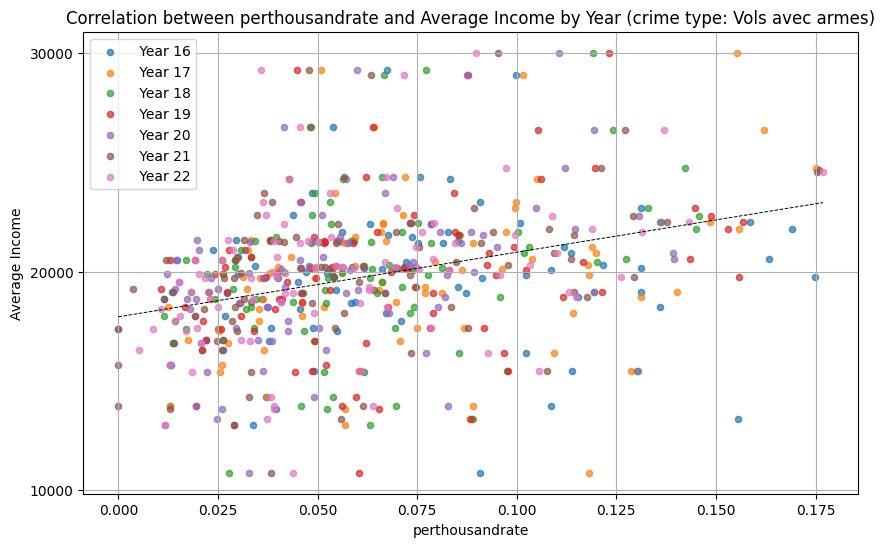

In [31]:
scatter_plot_occurrences("Average Income",10000, 10000, "Vols avec armes")

Upon closer examination through scatterplots, we discovere that there are instances where crime levels remain consistent despite significant variations in "Average Income". This variation in the relationship between "Average Income" and crime rates may help explain why the model does not give much importance to this feature.

**Conclusion** <br>
This section has shed light on an unexpected finding regarding the "Average Income" feature. Despite the common assumptions about its strong relationship with crime rates, it surprisingly ranks last in terms of contribution to our predictive model. <br>
The exploration of feature correlation led to the surprising result that "Average Income" feature exhibits a considerable correlation of $0.32$.<br>

By examining scatterplots, we gained deeper insights into the low distribution of "Average Income" and uncovered a potential explanation for the feature's relatively low importance in our model. Indeed, we observed data points with varying "Average Income" values but consistent crime levels.

There are other possible reasons why the model may not give much importance to "Average Income", despite its high correlation:

- The "Average Income" feature may be highly correlated with other features in the dataset, leading to multicollinearity. **Multicollinearity** is a statistical phenomenon that occurs when two or more independent variables (features) in a regression or predictive model are highly correlated with each other. In such cases, the model might prioritize other correlated features to avoid redundancy. It's possible, for example, that "Average Income" is highly correlated with "House Price", which has the second highest SHAP values. (22)

- Overfitting: the model excessively emphasizes certain features that may represent noise rather than signals. To mitigate this concern, future investigations could be done into the application of regularization techniques.

- Model Hyperparameters: it's important to acknowledge that the selection of other hyperparameters in the XGBoost model, beyond those already tuned, can significantly impact feature importance. Thus, an examination and tuning of these hyperparameters may potentially yield diverse outcomes, influencing the importance of different features. This investigation colud be done in a subsequent analyses. (23)

- Randomness: There's an element of randomness in how tree-based models like XGBoost split nodes and assign feature importance.

In conclusion, this unexpected finding highlights the importance of feature analysis in understanding model behavior and leaves the door open for other investigations.

#### Population Density: High Importance and Low Correlation

"Population Density" takes the spotlight as the feature with the highest SHAP value in our analysis. Common intuition suggests that areas with a high population density might be more prone to higher crime rates, potentially due to increased frustrations related to living conditions. This idea gains support from the SHAP Analysis, where we observe numerous pink data points on the right side of the graph, indicating that higher values of Population Density correspond to higher model predictions. <br>
The question we now face is whether this influential role played by "Population Density" aligns with the data's correlation. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


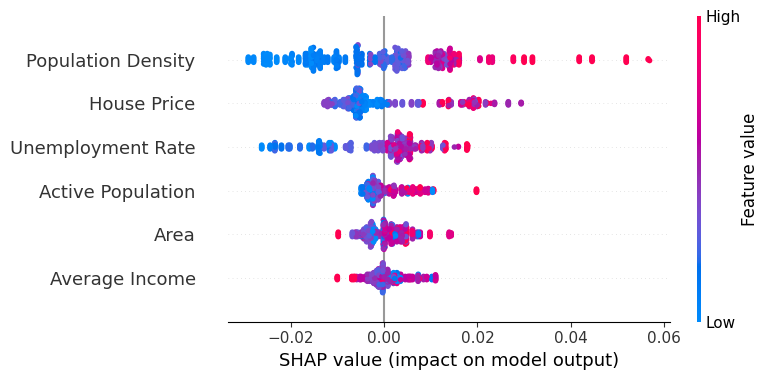

,Feature,Correlation
1,House Price,0.454803
2,Unemployment Rate,0.402590
3,Active Population,0.382762
4,Average Income,0.321154
5,Population Density,0.255099
6,Area,-0.177436


In [32]:
shap_analysis_summary_plot()
feature_correlations("Vols avec armes")

Surprisingly, "Population Density" exhibits a low correlation with our target variable ($0.26$).

In light of these findings, we must conclude that our data does not support the hypothesis that areas with high population density are more likely to result in higher crime rates, as these two factors exhibit a very weak correlation.

#### Population Density: High Values Impact

The presence of outliers on the right side of the "Population Density" contribution in the Beeswarm plot suggests that high values of this feature exceptionally impact generating higher predictions. These outliers could represent unique situations where a combination of factors, including high population density, results in exceptionally high predicted crime rates.<br>
This means that, when the model encounters instances with exceptionally high population density in the future, it may assign a relatively higher predicted crime rate to those instances based on the patterns it learned during training. <br>

**Identifying the Right Outliers** <br>
To better understand these outliers and their connection to high "Population Density", we will identify the datapoints associated with these outliers.

To identify the right outliers linked to the high SHAP values of "Population Density", we first extract the SHAP values for this feature and sort them. By retaining the two highest SHAP values, we find the outliers of interest.

In [33]:
def right_outlier_indices():
    shap_values, X_class = shap_analysis()
    shap_values_density = shap_values[:, 1]  #index are based on X_class, feature number 1 is 'Population Density'
    sorted_indices = np.sort(shap_values_density) 
    sorted_indices_unique = np.unique (sorted_indices)[-2:]
    return sorted_indices_unique,X_class,shap_values_density

sorted_indices_unique,X_class,shap_values_density= right_outlier_indices()
print(sorted_indices_unique)

[0.05669633 0.05698587]


In this case, the higher SHARP values correspons to $0.05669633$ and $0,05698587$ <br>
These high SHAP values correspond to specific datapoints, that we will retrieve from our dataset.

In [34]:
def top_entries_test_right():
    top_indices=[]

    for index,value in enumerate(shap_values_density) :
            if value in sorted_indices_unique:
                top_indices.append(index) 

    top_entries = X_class.iloc[top_indices] #real entries relarted to the ouliers 
    specific_data_df = pd.DataFrame(top_entries).T
    labels = specific_data_df.columns
    columns_to_print = ['crime type', 'year', 'occurrences','Department', 'Population']
    return merged_data_info_ville[columns_to_print].loc[labels]

top_entries_test_right()

,crime type,year,occurrences,Department,Population
6795,Vols avec armes,21,331,Rhône,1883437
9245,Vols avec armes,21,247,Val-de-Marne,1407972
9246,Vols avec armes,22,249,Val-de-Marne,1407972


By following this approach, we've extracted the rows from the original DataFrame (merged_data_info_ville) where the "Population Density" feature significantly contributed in increasing the prediction.<br>

**Understanding the Outliers** <br>
Our analysis unveils that these outliers are associated with two departments: "Rhône" and "Val-de-Marne." The next step is to determine whether the influence of "Population Density" is consistent across all data points in these departments or if it primarily impacts specific entries.

**Val-de-Marne** is the only department with a 'Population Density' of 5818, we use this fact.

In [35]:
print(f"Entries of 'Val-de-Marne' in X_class: {len(X_class[X_class['Population Density']==5818])}")

Entries of 'Val-de-Marne' in X_class: 2


In the portion of X_class used by SHAP, we find two entries associated with "Val-de-Marne." This suggests that "Population Density" significantly influenced all the datapoints from this department.

For **Rhône**, we have:

In [36]:
print(f"Entries of 'Rhône' in X_class: {len(X_class[X_class['Population Density'] == 579])}")

Entries of 'Rhône' in X_class: 1


In the subset of X_class used by SHAP, only one data point corresponds to "Rhône", the outlier we initially identified. This indicates that "Population Density" played a crucial role in predicting crime rates for this specific department.

Let's now explore this two departments, in particular the features "Population Density" and the number of "Vols avec armes" (armed robberies), in order to understand if the model was influenced by particulary high values. <br>

Let's try to better understand if the points for which the model gives the bigger importance to this feature are the ones with the highest "Population Density" in the dataset used by SHAP.  <br>
We will now find the 5 department in the subset of X_class where the "Population Density" is the highest.

In [39]:
def highest_house_x():

    sorted_data = X_class.sort_values(by='Population Density', ascending=False)
    sorted_data_merged = sorted_data.merge(merged_data_info_ville, left_on='Population Density', right_on='Population Density',how='inner')
    unique_departments = sorted_data_merged['Department'].unique()[:6]
    unique_departments_df = pd.DataFrame({'Department': unique_departments}, index=range(1, len(unique_departments) + 1))
    return unique_departments_df

highest_house_x()

,Department
1,Hauts-de-Seine
2,Val-de-Marne
3,Essonne
4,Yvelines
5,Rhône
6,Nord


It is worth noting that the second and fifth departments with the highest "Population Density" are the ones for which this feature has the most significant impact compared to all other departments.

**Interpreting the Findings** <br>
In conclusion, the model gives a lot of importance to the feature "Population Density" for all the entries of the departments "Val-de-Marne" and "Rhône".  
These departments are the second and fifth departments with the highest "Population Density" in the dataset used to calculate SHAP values.  We can conclude that it's possible that the model has learned that instances with a very "Population Density" values are associated with a very high predicted crime rates.

It's essential to note that this doesn't necessarily imply a direct causal link between high population density and a high crime rate in general. Instead, we should consider the model's emphasis on this feature in these specific data points.

Further investigation into the social and economic factors driving these patterns in these two departments could be intresing. Even if a correlation between the number of crimes and population density exists in these areas, caution is advised with this model in predicting the number of armed robberis with data points with high population densitys.

#### House Price: a Direct Proportionality and the Higher Values Influence 

In the following two sections, we delve into an analysis of the "House Price" feature, exploring its correlation with armed robbery rates and its impact on predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


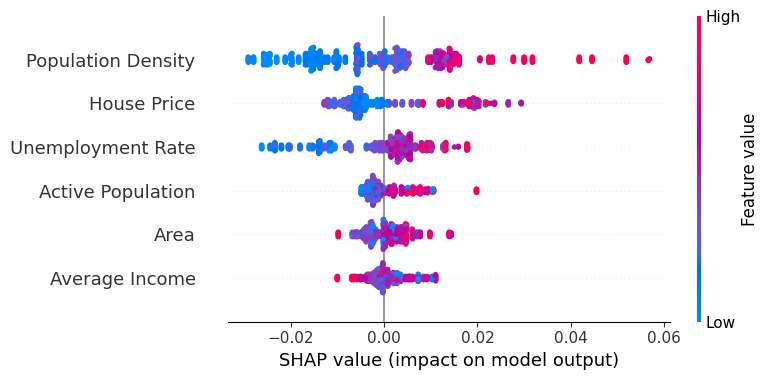

In [38]:
shap_analysis_summary_plot()

From the graph, regarding the "House Price" feature, it is noteworthy that higher values exert a significant influence on predicting a higher number of robberies while lower values correspond to predictions of lower robbery rates. <br>

This observation can lead to further investigations into whether this relationship is reflected in the data's correlations.<br>
Indeed, we can imagine that a strong correlation between housing costs and the incidence of armed robberies might influence the model's behavior. <br>

In [40]:
feature_correlations("Vols avec armes")

,Feature,Correlation
1,House Price,0.454803
2,Unemployment Rate,0.402590
3,Active Population,0.382762
4,Average Income,0.321154
5,Population Density,0.255099
6,Area,-0.177436


It is evident that, within the "Vols avec armes" class, there exists a substantial correlation between the housing cost and the number of crimes. Specifically, this feature exhibits the highest correlation among all the features. <br>
This observation reaffirms the direct proportionality inherent in the model. <br>

**Scatter plot** <br>

Previous observations have noted that the "House Price" feature plays an important role in predicting crime rates, following a direct proportionality. <br>
The scatterplot reveals a trend across all years: the majority of locations exhibit both a low number of "Vols avec armes" (armed robberies) and a low cost of houses.  

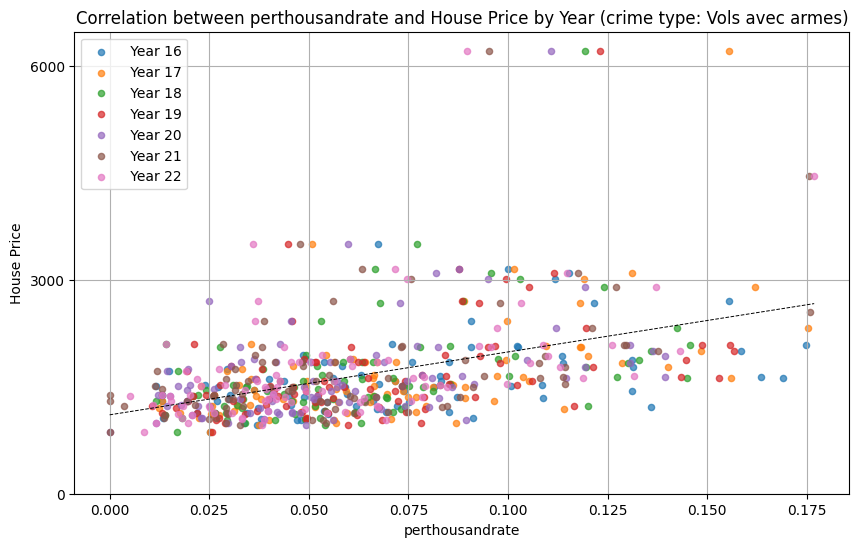

In [41]:
scatter_plot_occurrences("House Price",0,3000,"Vols avec armes")

Given the pattern observed in the scatterplot, where the majority of data points are clustered within a low "House Price" range, one might anticipate that the feature "House Price" would exert more influence when it presents higher values.

We aim to evaluate if this anticipation aligns with the SHAP Beeswarm Plot, particularly focusing on the influence of high "House Price" values on armed robbery predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


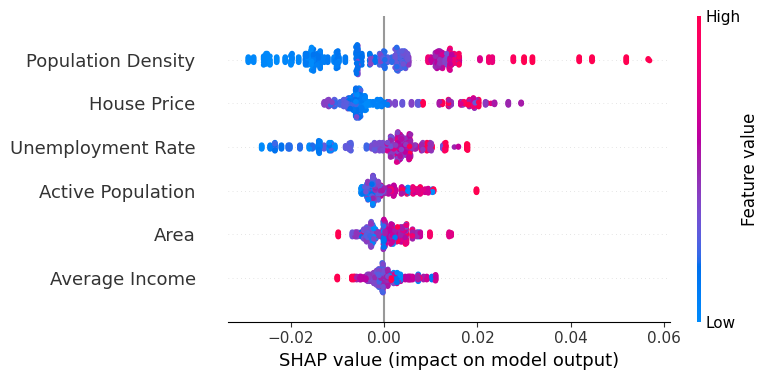

In [42]:
shap_analysis_summary_plot()

From the position on pink dots, it holds true that high "House Price" values do manifest a bigger impact on overestimating of armed robberies compared to the impact of low values in underestimating. 

**Conclusions** <br>
In conclusion, our analysis of the "House Price" feature has shed light on two aspects of its impact on predicting armed robbery rates. Firstly, the common assumption that a rising in housing costs is associated with increased criminal activity, is confirmed. Moreover, high "House Price" values do exhibit a greater influence on overestimating armed robberies compared to the one exhibited by low values on underestimating. 

#### The Significance of Active Population Composition in Predicting Armed Robberies

"Active Population" refers to the all individuals of working age available in the labor market.  It's a fraction of the working-age population, all individuals between 15 and 64 years of age. 

The Working-Age Population is, indeed, divided into two cathegories:

<li>The "Active Population", , with the former further divided into two categories: <br>
    - Those actively seeking employment (constituting the non-employed active population, reflected in the "Unemployment Rate")  <br>
    - Those currently employed <br>

<li>The inactive population is defined as all working-age individuals who are neither employed nor actively seeking employment. This category includes homemakers, students, individuals unable to work, volunteers, and retirees. (21)

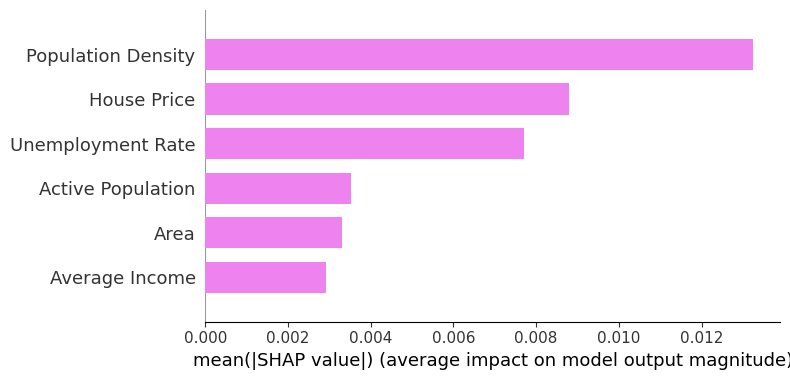

,Feature,Correlation
1,House Price,0.454803
2,Unemployment Rate,0.402590
3,Active Population,0.382762
4,Average Income,0.321154
5,Population Density,0.255099
6,Area,-0.177436


In [43]:
shap_analysis_bp_plot()
feature_correlations("Vols avec armes")

From the SHAP analysis, it is clear that what most influences the model is not the size of the "Active Population", but rather the fraction of that population which is not employed ("Unemployement Rate"). In essence, the model places greater importance on how the active population is segmented rather than its sheer magnitude.

This observation aligns with our correlation analysis, which also underscores the importance of the "Unemployment Rate" as a more influential factor (correlation coefficient: 0.4) compared to the "Active Population" (correlation coefficient: 0.38). Although the difference in correlation strength between these two features is not as pronounced as in the SHAP plot, it reaffirms the model's preference for the employment composition within the active population.

Furthermore, our analysis reveals a positive correlation between the proportion of active population and the crime rate for "Vols avec armes" (armed robberies). This implies that an increase in the proportion of active individuals, accompanied by a reduction in the number of inactive individuals such as students, homemakers, and retirees, is associated with an escalation in the crime rate. <br>

**Conclusions** <br>
The model's predictions for "Vols avec armes" (armed robberies) are significantly influenced by the composition of the "Active Population," rather than just its overall size. This observation aligns with our correlation analysis, which highlights the "Unemployment Rate" as a more strongly correlated factor.


Furthermore, the positive correlation between the proportion of active individuals and the crime rate for armed robberies underscores specific social dynamics. An increased proportion of active individuals, accompanied by a decrease in the number of homemakers, students, individuals unable to work, volunteers, or retirees, is associated with a higher incidence of these crimes. This finding is surprising and raises questions about the complex relationship between employment dynamics and crime rates.

#### Area: Negative Correlation and a Mixed Picture

In [44]:
feature_correlations("Vols avec armes")

,Feature,Correlation
1,House Price,0.454803
2,Unemployment Rate,0.402590
3,Active Population,0.382762
4,Average Income,0.321154
5,Population Density,0.255099
6,Area,-0.177436


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


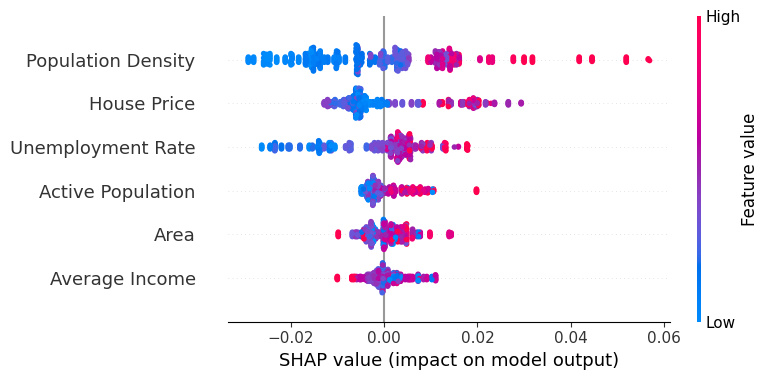

In [45]:
shap_analysis_summary_plot()

Our feature analysis culminates with a focus on the "Area" feature, which exhibits intriguing characteristics. Having the second-lowest impact in the SHAP Analysis, it shows also a low negative correlation with the rate of "Vols avec armes" (armed robberies), correlation coefficient:$-0.18$.  <br>

This negative correlation implies that as the area increases, the number of "Vols avec armes" (armed robberies) tends to decrease, and conversely, as the area decreases, the number of "Vols avec armes" tends to increase. <br>
However, the absolute correlation value is relatively low, and the scatterplot illustrates a highly diverse relationship. With this feature, it's very challenging to discern the precise connection between its growth and the increase in the number of crimes. 

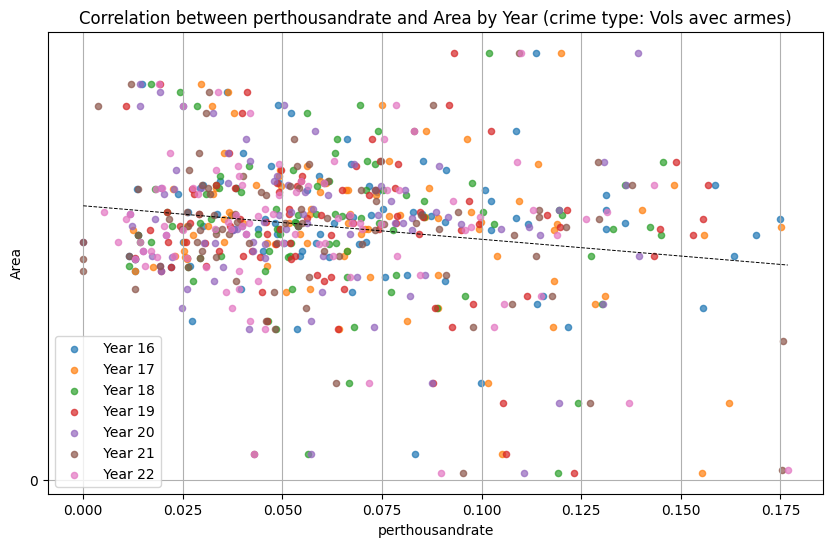

In [46]:
scatter_plot_occurrences("Area",0,10000,"Vols avec armes")

Indeed, the SHAP analysis shows that the model considers various scenarios: there are instances where larger areas lead to a decrease in the predicted values, cases where larger areas increase predictions, and the same for smaller area values.
Moreover, in general, the most significant increase or decrease in predicted values is associated with higher area values.

**Conclusion**<br>
In essence, the "Area" feature's impact on predictions is multifaceted, and while the correlation suggests a negative trend, the SHAP analysis underscores the nuanced relationship between area size and the predicted number of crimes. 

#### Conclusion

In summary, our extensive feature analysis has uncovered intriguing insights into the relationships between key features and armed robbery rates. While correlation analysis provides valuable insights, SHAP analysis offers a more nuanced understanding of feature significance in our predictive model.

The unexpected findings surrounding "Average Income" highlight the importance of of a comprehensive feature analysis in understanding model behavior, highlight the possibility to do future investigations on multicollinearity, regularization and hyperparameters tuning.

In the case of "Population Density", the correlation analysis was not alliged with the SHAP result. Morevoer, it made us advise caution with this model using data points with very high population denisty.

Our investigation into the "House Price" feature has illuminated two aspects of its impact on predicting armed robbery rates. Firstly, it reaffirms the common assumption that an increase in housing costs is associated with heightened criminal activity. Moreover, it highlights that high "House Price" values have a more pronounced impact on overestimating armed robberies than their low counterparts do in underestimating.

The composition of the "Active Population", more that its size, plays a pivotal role in the model's predictions, with correlation analysis reinforcing this observation.
Moreover, the positive correlation between the proportion of active individuals and the crime rate for armed robberies underscores questions regarding the interplay between employment dynamics and crime rates.

The "Area" feature presents a unique case, where correlation is negative. SHAP analysis and scatterplots unveil a intricate relationship between this feature and the "Vols avec armes" (armed robberies). 

Ultimately, this chapter highlights the value of combining traditional statistical analysis with machine learning interpretability tools like SHAP to gain a comprehensive understanding of feature importance. The insights gained from these analyses offer valuable perspectives for improving our predictive model and guiding future investigations into the intricate dynamics of crime rates.

## Conclusion

The project begins a the first part which focuses on data preparation, data cleaning, and descriptive analysis. This initial phase sets the foundation for subsequent analyses.

In the second chapter, the project delves into the development of predictive models for crime rates. Specifically, Random Forest and two XGBoost Models, one General and one Class-Specific, were implemented. The evaluation metric used across all models was the Mean Squared Error (MSE). 

A critical step in this chapter was hyperparameter tuning for the XGBoost model, accomplished through GridSearchCV. This systematic exploration of various hyperparameter combinations helped identify the best model configuration with the lowest MSE. The tuned General XGBoost Model significantly improved its performance compared to the initial model, with the best hyperparameters identified.

However, in the case of the Class-Specific Model, the hyperparameter tuning process unexpectedly led to a model with a higher MSE compared to the untuned version. This outcome was attributed to the internal cross-validation implemented by GridSearchCV.

The project then proceeded to compare the performance of the best General Model and the best Class-Specific Model for predicting "Vols avec armes" (armed robberies). Notably, the Class-Specific Model outperformed the General Model by exhibiting an impressively low MSE, indicating its precision in predicting this specific crime type. The reasons behind this superior performance were attributed to factors such as model complexity and feature relevance. The Class-Specific Model's focused nature allowed it to capture finer details and emphasize features relevant to the specific crime type.

This comparison underscores the significance of employing class-specific models for crime prediction tasks. These models enable more precise predictions and facilitate resource allocation tailored to specific crime categories. Such an approach can greatly benefit law enforcement agencies in optimizing resource allocation and enhancing crime prevention efforts.

In the third chapter, the project leveraged SHAP (SHapley Additive exPlanations) to gain insights into the contribution of each feature to the Class-Specific Model's predictions. SHAP values were computed to quantify how the presence or absence of each feature influenced the model's predictions. Visualizations such as the Bar Plot and Beeswarm Plot were employed to illustrate feature importance.

The analysis focused on six key features: "Average Income," "Population Density," "House Price," "Unemployment Rate," "Active Population," and "Area." The results yielded several intriguing findings:

1. The "Average Income" feature exhibited an unexpected underperformance, challenging the common assumption of a strong correlation between income level and crime rates. Potential explanations for this disconnect included its distribution, multicollinearity with other features, overfitting and model hyperparameters.

2. "Population Density" emerged as a feature of high importance in the SHAP analysis, despite showing a low correlation with the target variable. This emphasized the need to consider SHAP values alongside traditional correlation analysis. Notably, the presence of some outliers on the Beeswarm plot suggests that high values of this feature exceptionally impact generating higher predictions.

3. "House Price" demonstrated a direct proportionality with armed robbery rates, aligning with both correlation and SHAP analyses, with high "House Price" values exhibiting a greater influence.

4. The composition of the "Active Population", particularly the "Unemployment Rate", played a significant role in shaping the model's outcomes. Additionally, a positive correlation was observed between the proportion of active individuals and armed robbery rates, highlighting a surprising connection between employment dynamics and crime rates.

5. The "Area" feature presented a unique case with a negative correlation with armed robbery rates. However, this value is low and the SHAP analysis and scatterplots unveiled a more intricate relationship, where both higher and lower area values could impact predictions.

In summary, this project represents step toward leveraging data-driven approaches to address complex societal challenges. It encompasses an investigation into crime rate prediction, spanning critical phases such as data preparation, model development, and intricate feature analysis. <br>
The utilization of advanced machine learning techniques, including Random Forest and XGBoost, allowed for the creation of predictive models with varying degrees of precision.<br>
The Class-Specific Model, tailored specifically for "Vols avec armes" (armed robberies), emerged as the standout performer, underscoring the value of class-specific models in crime prediction. <br>
The integration of SHAP analysis added an interpretability layer to our models, shedding light on the contribution of individual features to predictions. This analysis uncovered unexpected findings, challenging conventional assumptions about the relationship between certain features and crime rates. The implications of these findings suggest potential avenues for model refinement and further research into the multifaceted dynamics of crime rates. Moreover, as a future enhancement, the project can benefit from the incorporation of demographic data associated with each year, providing a more comprehensive context for crime rate prediction. 

In conclusion, this project represents a comprehensive exploration of crime rate prediction, encompassing data preparation, model development, and detailed feature analysis. By combining machine learning, interpretability tools, and in-depth feature analysis, we have laid a solid foundation for future research and practical applications in the realm of crime rate prediction.

### REFERENCES 

(1)	https://dl.acm.org/doi/abs/10.1145/1103780.1103784  <br>
(2)	https://cs.brown.edu/courses/cs227/archives/2017/papers/data-cleaning-IEEE.pdf#page=5 <br>
(3)	https://stevage.github.io/geojson-spec/<br>
(4)	https://geojson.org<br>
(5)	https://link.springer.com/article/10.1023/A:1010933404324 <br>
(6)	https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/<br>
(7)	https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680<br>
(8)	https://towardsdatascience.com/assessing-model-performance-for-regression
-7568db6b2da0<br>
(9)	https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html<br>
(10)	https://xgboost.readthedocs.io/en/latest/index.html<br>
(11)	https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf<br>
(12)	https://scikit-learn.org/stable/modules/grid_search.html<br>
(13)	https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/<br>
(14)	https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b<br>
(15)	https://shap.readthedocs.io/en/latest/<br>
(16)	https://github.com/shap/shap<br>
(17)	https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability<br>
(18)	https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html<br>
(19)	https://arxiv.org/pdf/2002.11097.pdf<br>
(20)	https://christophm.github.io/interpretable-ml-book/shap.html<br>
(21)	https://fr.wikipedia.org/wiki/Population_active<br>
(22)	https://wires.onlinelibrary.wiley.com/doi/abs/10.1002/wics.84<br>
(23)	https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76<br>
(24)    https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac <br>
(25)    https://towardsdatascience.com/what-is-better-one-general-model-or-many-specialized-models-9500d9f8751d <br>